In [70]:
import sys
sys.path.append("../")

In [83]:
import pandas as pd
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot

from infrastructure.quotehistory_collection import quotehistoryCollection as qc

In [135]:
pair = "XAUUSD"
df_raw = pd.read_pickle(f"../data/H4/{pair}_H4.pkl")

In [136]:
df_an = df_raw.copy()#df_raw.iloc[-6000:].copy()
df_an.reset_index(drop=True, inplace=True)

In [137]:
df_an.tail()

,time,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,mid_o,mid_h,mid_l,mid_c
10845,2024-09-16 00:00:00,2579.16,2588.87,2578.85,2586.35,2579.28,2589.24,2579.08,2586.49,2579.220,2589.055,2578.965,2586.420
10846,2024-09-16 04:00:00,2586.36,2589.63,2579.55,2582.14,2586.51,2589.80,2579.75,2582.27,2586.435,2589.715,2579.650,2582.205
10847,2024-09-16 08:00:00,2582.12,2588.48,2575.37,2583.00,2582.25,2588.50,2575.52,2583.15,2582.185,2588.490,2575.445,2583.075
10848,2024-09-16 12:00:00,2583.02,2589.33,2576.12,2579.96,2583.17,2589.44,2576.29,2580.04,2583.095,2589.385,2576.205,2580.000
10849,2024-09-16 16:00:00,2579.97,2584.12,2579.56,2582.54,2580.05,2584.29,2579.70,2582.68,2580.010,2584.205,2579.630,2582.610


In [138]:
BUY = 1
SELL = -1
NONE = 0

def apply_signal_long(row):
    if row.DELTA >= 0 and row.DELTA_PREV < 0:
        return BUY
    elif row.DELTA < 0 and row.DELTA_PREV >= 0:
        return SELL
    return NONE

In [139]:
ema_1 = 10
ema_2 = 30
df_an[f'EMA_{ema_1}'] = df_an.mid_c.ewm(span=ema_1, min_periods=ema_1).mean()
df_an[f'EMA_{ema_2}'] = df_an.mid_c.ewm(span=ema_2, min_periods=ema_2).mean()

df_an.reset_index(drop=True, inplace=True)




In [140]:
df_an['DELTA'] = df_an[f'EMA_{ema_1}'] - df_an[f'EMA_{ema_2}']
df_an['DELTA_PREV'] = df_an.DELTA.shift(1)

df_an['SIGNAL'] = df_an.apply(apply_signal_long, axis=1)

df_an.dropna(inplace=True)
df_an.reset_index(drop=True, inplace=True)

In [141]:
df_an.columns

Index(['time', 'bid_o', 'bid_h', 'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l',
       'ask_c', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'EMA_10', 'EMA_30',
       'DELTA', 'DELTA_PREV', 'SIGNAL'],
      dtype='object')

In [142]:
df_slim = df_an.copy()


In [143]:
df_slim["SIGNAL"].value_counts()

SIGNAL
 0    10438
-1      191
 1      191
Name: count, dtype: int64

In [157]:
SL = 1000
TP = 200
def apply_take_profit(row, pip_location):
    # Define o valor do pip
    pip_value = pip_location
    
    if row.SIGNAL == BUY:
        return row.mid_c + (pip_value*TP)
    elif row.SIGNAL == SELL:
        return row.mid_c - (pip_value*TP)
    else:
        return 0.0

def apply_stop_loss(row, pip_location):
    # Define o valor do pip
    pip_value = pip_location
    
    if row.SIGNAL == BUY:
        return row.mid_c - (pip_value*SL)
    elif row.SIGNAL == SELL:
        return row.mid_c + (pip_value*SL)
    else:
        return 0.0

In [158]:
qc.LoadQuotehistory("../data")
quotehistory = qc.quotehistory_dict[pair]
pip_location = quotehistory.pipLocation * 0.1
df_slim["TP"] = df_slim.apply(lambda row: apply_take_profit(row,pip_location), axis=1)
df_slim["SL"] = df_slim.apply(lambda row: apply_stop_loss(row, pip_location), axis=1)

In [159]:
df_slim.head()

,time,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,mid_o,mid_h,mid_l,mid_c,EMA_10,EMA_30,DELTA,DELTA_PREV,SIGNAL,TP,SL
0,2018-01-09 00:00:00,1320.14,1320.29,1316.00,1317.85,1320.14,1320.29,1316.00,1317.85,1320.14,1320.29,1316.00,1317.85,1318.703510,1317.590857,1.112654,1.323452,0,0.00,0.00
1,2018-01-09 04:00:00,1317.85,1320.13,1317.85,1319.30,1317.85,1320.13,1317.85,1319.30,1317.85,1320.13,1317.85,1319.30,1318.812140,1317.715926,1.096214,1.112654,0,0.00,0.00
2,2018-01-09 08:00:00,1319.30,1319.53,1313.23,1315.41,1319.30,1319.53,1313.23,1315.41,1319.30,1319.53,1313.23,1315.41,1318.192745,1317.548635,0.644110,1.096214,0,0.00,0.00
3,2018-01-09 12:00:00,1315.40,1315.90,1310.54,1312.49,1315.40,1315.90,1310.54,1312.49,1315.40,1315.90,1310.54,1312.49,1317.154752,1317.184565,-0.029813,0.644110,-1,1310.49,1322.49
4,2018-01-09 16:00:00,1312.49,1313.21,1308.81,1311.74,1312.49,1313.21,1308.81,1311.74,1312.49,1313.21,1308.81,1311.74,1316.169374,1316.795618,-0.626244,-0.029813,0,0.00,0.00


In [160]:
df_slim[df_slim.SIGNAL==SELL].head()

,time,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,mid_o,mid_h,mid_l,mid_c,EMA_10,EMA_30,DELTA,DELTA_PREV,SIGNAL,TP,SL
3,2018-01-09 12:00:00,1315.40,1315.90,1310.54,1312.49,1315.40,1315.90,1310.54,1312.49,1315.40,1315.90,1310.54,1312.49,1317.154752,1317.184565,-0.029813,0.644110,-1,1310.49,1322.49
45,2018-01-18 12:00:00,1328.65,1331.38,1326.84,1329.98,1328.65,1331.38,1326.84,1329.98,1328.65,1331.38,1326.84,1329.98,1331.298756,1331.385421,-0.086666,0.108809,-1,1327.98,1339.98
89,2018-01-29 20:00:00,1341.63,1344.57,1339.49,1339.89,1341.63,1344.57,1339.49,1339.89,1341.63,1344.57,1339.49,1339.89,1346.574038,1346.743710,-0.169672,0.842831,-1,1337.89,1349.89
111,2018-02-02 12:00:00,1345.73,1346.95,1335.25,1335.50,1345.73,1346.95,1335.25,1335.50,1345.73,1346.95,1335.25,1335.50,1343.164206,1343.648879,-0.484673,0.656446,-1,1333.50,1345.50
184,2018-02-20 16:00:00,1336.46,1343.20,1329.15,1329.39,1336.46,1343.20,1329.15,1329.39,1336.46,1343.20,1329.15,1329.39,1340.502463,1342.030685,-1.528222,0.069442,-1,1327.39,1339.39


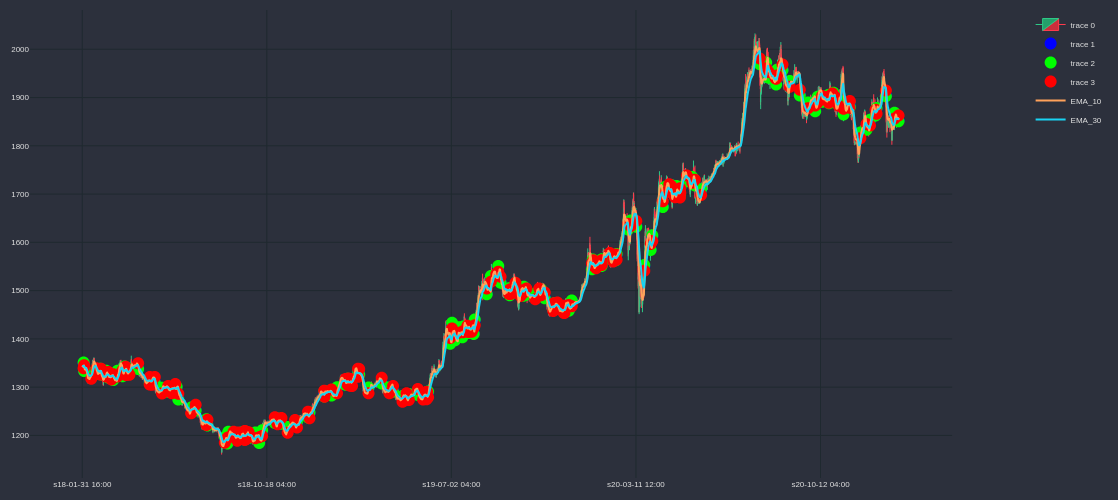

In [161]:
df_plot = df_slim.iloc[100:5000]
cp = CandlePlot(df_plot, candles=True)

trades = cp.df_plot[cp.df_plot.SIGNAL != NONE]

markers = ['mid_c', 'TP', 'SL']
marker_colors = ['#0000FF', '#00FF00', '#FF0000']

for i in range(3):
    cp.fig.add_trace(go.Scatter(
        x = trades.sTime,
        y = trades[markers[i]],
        mode = 'markers',
        marker=dict(color=marker_colors[i], size=12)
    ))

cp.show_plot(line_traces=["EMA_10","EMA_30"], height=500)

In [200]:
class Trade:
    def __init__(self, row):
        self.running = True
        self.start_index = row.name
        self.start_price = row.mid_c
        self.trigger_price = row.mid_c
        self.SIGNAL = row.SIGNAL
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 0
        
    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price
        
    def update(self, row, optimistic=True):
        self.duration += 1

        if optimistic == True:
            if self.SIGNAL == BUY:
                if row.mid_h >= self.TP:
                    self.close_trade(row, TP, row.mid_h)
                elif row.mid_l <= self.SL:
                    self.close_trade(row, -SL, row.mid_l)
                elif self.SIGNAL == SELL:
                    result = (row.mid_c - self.start_price) / pip_value
                    self.close_trade(row, result, row.mid_l)
            if self.SIGNAL == SELL:
                if row.mid_l <= self.TP:
                    self.close_trade(row, TP, row.mid_l)
                elif row.mid_h >= self.SL:
                    self.close_trade(row, -SL, row.mid_h)    
                elif self.SIGNAL == BUY:
                    result = (self.start_price - row.mid_c) / pip_value
                    self.close_trade(row, result, row.mid_l)
        else:
            if self.SIGNAL == BUY:
                if row.mid_l <= self.SL:
                    self.close_trade(row, -SL, row.mid_l)
                elif row.mid_h >= self.TP:
                    self.close_trade(row, TP, row.mid_h)
                elif self.SIGNAL == SELL:
                    result = (row.mid_c - self.start_price) / pip_value
                    self.close_trade(row, result, row.mid_l)
            if self.SIGNAL == SELL:
                if row.mid_h >= self.SL:
                    self.close_trade(row, -SL, row.mid_h)    
                elif row.mid_l <= self.TP:
                    self.close_trade(row, TP, row.mid_l)
                elif self.SIGNAL == BUY:
                    result = (self.start_price - row.mid_c) / pip_value
                    self.close_trade(row, result, row.mid_l)

In [201]:
open_trades = []
closed_trades = []

for index, row in df_slim.iterrows():
    for ot in open_trades:
        ot.update(row,optimistic=True)
        if ot.running == False:
            closed_trades.append(ot)
    open_trades = [x for x in open_trades if x.running == True]
    
    if row.SIGNAL != NONE:
        open_trades.append(Trade(row))   

In [202]:
df_results = pd.DataFrame.from_dict([vars(x) for x in closed_trades])

In [203]:
df_results.head()

,running,start_index,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time,duration
0,False,3,1312.49,1308.81,-1,1310.49,1322.49,200,2018-01-09 16:00:00,2018-01-09 12:00:00,1
1,False,13,1317.78,1322.63,1,1319.78,1307.78,200,2018-01-11 12:00:00,2018-01-11 04:00:00,2
2,False,45,1329.98,1325.49,-1,1327.98,1339.98,200,2018-01-18 20:00:00,2018-01-18 12:00:00,2
3,False,50,1335.50,1338.13,1,1337.50,1325.50,200,2018-01-23 08:00:00,2018-01-19 08:00:00,12
4,False,89,1339.89,1334.40,-1,1337.89,1349.89,200,2018-01-30 04:00:00,2018-01-29 20:00:00,2


In [210]:
df_results.shape, df_results[df_results['result'] > 0].shape, df_results[df_results['result'] < 0].shape

((382, 11), (329, 11), (53, 11))

In [204]:
df_results.result.sum()

np.int64(12800)

In [205]:
df_results.sort_values(by="start_index", inplace=True)

In [206]:
df_m5 = pd.read_pickle("../data/M5/XAUUSD_M5.pkl")

In [168]:
df_m5.tail()

,time,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,mid_o,mid_h,mid_l,mid_c
419682,2024-09-16 20:25:00,2582.92,2583.02,2582.79,2582.90,2583.06,2583.14,2582.93,2583.03,2582.990,2583.080,2582.86,2582.965
419683,2024-09-16 20:30:00,2582.88,2583.36,2582.86,2583.30,2583.01,2583.52,2583.00,2583.47,2582.945,2583.440,2582.93,2583.385
419684,2024-09-16 20:35:00,2583.31,2583.36,2581.97,2582.05,2583.48,2583.51,2582.15,2582.22,2583.395,2583.435,2582.06,2582.135
419685,2024-09-16 20:40:00,2581.98,2582.54,2581.89,2582.50,2582.29,2582.84,2582.13,2582.80,2582.135,2582.690,2582.01,2582.650
419686,2024-09-16 20:45:00,2582.53,2582.93,2582.25,2582.73,2582.80,2583.21,2582.55,2583.02,2582.665,2583.070,2582.40,2582.875


In [211]:
329*200, 53*1000

(65800, 53000)